In [3]:
# Cell 1: Import Libraries
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from src.model import create_model
from src.data_loader import get_data_generators
import matplotlib.pyplot as plt
import numpy as np
import os

# Paths
train_dir = "../data/train"
val_dir = "../data/val"
test_dir = "../data/test"  # Optional folder for evaluation
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 20
MODEL_PATH_INITIAL = "../models/efficientnet_apple_model.h5"
MODEL_PATH_FINETUNE = "../models/efficientnet_apple_finetuned.h5"

os.makedirs("../models", exist_ok=True)
os.makedirs("../outputs", exist_ok=True)

In [5]:
# Cell 2: Load Data using data_loader.py
train_dataset, val_dataset = get_data_generators(train_dir, val_dir)

# Check number of images and classes
print(f"Number of training batches: {len(train_dataset)}")
print(f"Number of validation batches: {len(val_dataset)}")
print(f"Classes: {train_dataset.class_indices}")
print(f"Number of classes: {train_dataset.num_classes}")


Found 3171 images belonging to 4 classes.
Found 3171 images belonging to 4 classes.
Number of training batches: 100
Number of validation batches: 100
Classes: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3}
Number of classes: 4


In [6]:
# Cell 3: Create Model
model = create_model(num_classes=NUM_CLASSES, input_shape=(224,224,3))
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
# Cell 4: Callbacks for Initial Training
checkpoint_cb = ModelCheckpoint(MODEL_PATH_INITIAL, save_best_only=True, monitor="val_accuracy", verbose=1)
earlystop_cb = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

In [10]:
# Cell 5: Train Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.4276 - loss: 1.2935
Epoch 1: val_accuracy improved from None to 0.51876, saving model to ../models/efficientnet_apple_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.4910 - loss: 1.2413 - val_accuracy: 0.5188 - val_loss: 1.1931
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.5149 - loss: 1.2066
Epoch 2: val_accuracy did not improve from 0.51876
100/100 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.5188 - loss: 1.2072 - val_accuracy: 0.5188 - val_loss: 1.1928
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.5142 - loss: 1.2128
Epoch 3: val_accuracy did not improve from 0.51876
100/100 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.5188 - loss: 1.2044 - val_accuracy: 0.5188 - val_loss: 1.1984
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.5126 - loss: 1.2141
Epoch 4: val_accuracy did not improve from 0.51876
100/100 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.5188 - loss: 1.2056 - val_accuracy: 0.5188 - val_loss: 1.1943
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.5110 - loss: 1.2078
Epoch 5: val_accuracy d

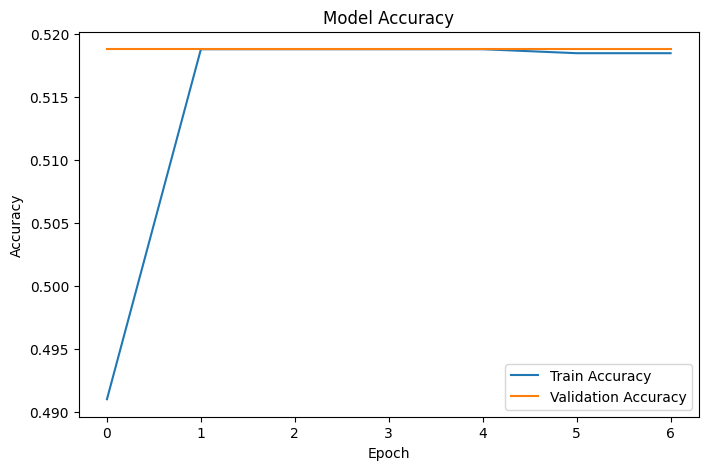

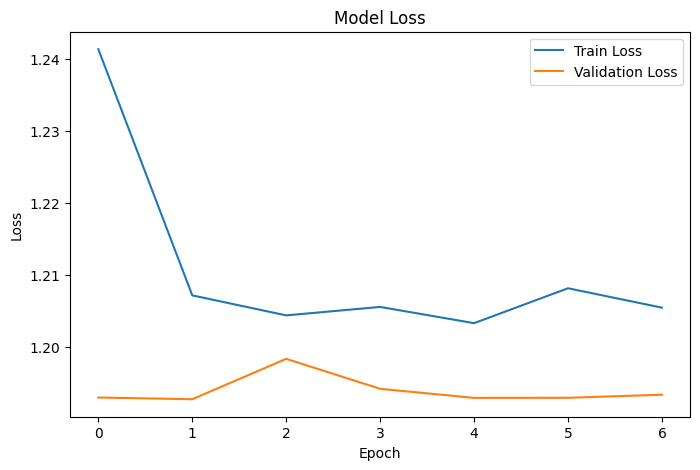

In [11]:
# Cell 6: Plot Accuracy & Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("../outputs/accuracy_plot.png")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("../outputs/loss_plot.png")
plt.show()

In [24]:
# Cell 7: Load the pre-trained model

from src.model import create_model

# Recreate the model architecture
model = create_model(num_classes=4, input_shape=(224,224,3))

# Load previously trained weights
MODEL_PATH_INITIAL = "../models/efficientnet_apple_model.h5"
model.load_weights(MODEL_PATH_INITIAL)

# Check model summary
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_12        │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_6     │ (None, 224, 224,  │          7 │ rescaling_12[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_13        │ (None, 224, 224,  │          0 │ normalization_6[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_13[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [28]:
# Cell 8: Unfreeze last 50 layers for fine-tuning

# The base model is all layers except the last Dense + Dropout
# We can freeze first N layers and leave the last 50 trainable
for layer in model.layers[:-3]:   # last 3 layers: GlobalAveragePooling2D, Dropout, Dense
    layer.trainable = False

for layer in model.layers[-53:-3]:  # unfreeze last 50 layers of the base
    layer.trainable = True

# Compile the model with a lower learning rate
import tensorflow as tf
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Check number of trainable layers
trainable_count = sum([layer.trainable for layer in model.layers])
print(f"Number of trainable layers: {trainable_count}")


Number of trainable layers: 53


In [29]:
# Cell 9: Train the model (fine-tuning)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

EPOCHS_FINE_TUNE = 10  # You can adjust based on your dataset
BATCH_SIZE = 32

# Callbacks
checkpoint_cb = ModelCheckpoint(
    "../models/efficientnet_apple_model_finetuned.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

# Train the model
history_finetune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS_FINE_TUNE,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.2706 - loss: 1.4562

100/100 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.3623 - loss: 1.3668 - val_accuracy: 0.5188 - val_loss: 1.2021
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.5074 - loss: 1.2201 - val_accuracy: 0.5188 - val_loss: 1.2144
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.5156 - loss: 1.2050 - val_accuracy: 0.5188 - val_loss: 1.2255
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.5150 - loss: 1.2058 - val_accuracy: 0.5188 - val_loss: 1.2068
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.5169 - loss: 1.2056 - val_accuracy: 0.5188 - val_loss: 1.1991
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5175 - loss: 1.2055 - val_accuracy: 0.5188 - val_loss: 1.1997


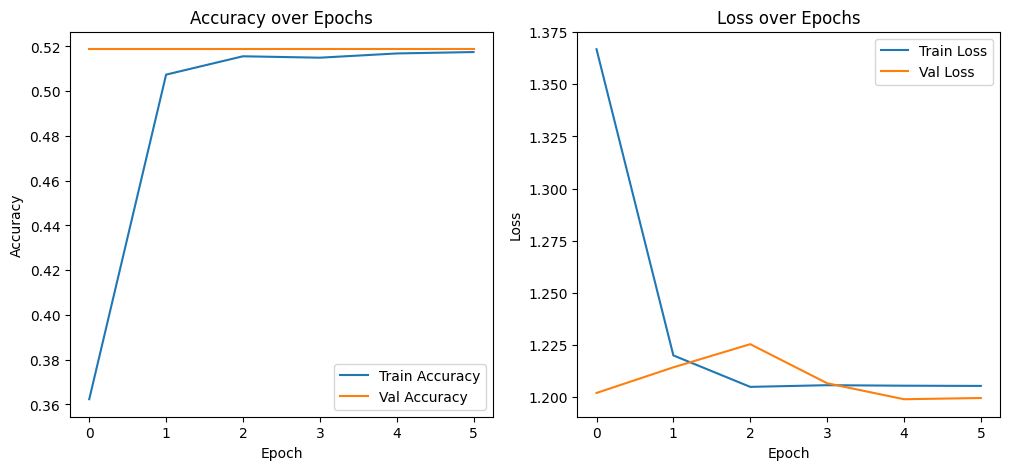

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [31]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 477ms/step - accuracy: 0.5188 - loss: 1.2021
Validation Accuracy: 0.5188
Validation Loss: 1.2021


In [32]:
model.save("../models/efficientnet_apple_model_finetuned.keras")